## 04_DataPreprocessing.ipynb

### 🎯 Objective
Prepare the cleaned dataset for machine learning by:
- Augmenting images
- Splitting into train, validation, and test folders

### 🔧 Steps
- Organize dataset into 3 subsets
- Maintain label directories
- Save structured data into an output folder


In [5]:
from pathlib import Path
import shutil
import random

def organize_dataset_into_subsets(image_dir, output_dir, splits=(0.7, 0.2, 0.1)):
    """
    Organizes the dataset into train, validation, and test folders.
    Skips hidden folders and filters only valid image formats.
    """
    valid_extensions = ['.jpg', '.jpeg', '.png']
    image_dir = Path(image_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True)

    # Skip hidden/system folders like .ipynb_checkpoints
    labels = [d.name for d in image_dir.iterdir() if d.is_dir() and not d.name.startswith('.')]
    print(f"Found labels: {labels}")

    for label in labels:
        files = [
            f for f in (image_dir / label).iterdir()
            if f.is_file() and not f.name.startswith('.') and f.suffix.lower() in valid_extensions
        ]
        random.shuffle(files)

        train_count = int(splits[0] * len(files))
        val_count = int(splits[1] * len(files))

        subsets = {
            "train": files[:train_count],
            "validation": files[train_count:train_count + val_count],
            "test": files[train_count + val_count:]
        }

        for subset_name, subset_files in subsets.items():
            subset_path = output_dir / subset_name / label
            subset_path.mkdir(parents=True, exist_ok=True)

            for file in subset_files:
                shutil.copy(file, subset_path)

    print("\n✅ Dataset split complete.")
    for subset in ["train", "validation", "test"]:
        total = sum(1 for _ in (output_dir / subset).rglob("*.*"))
        print(f"{subset.capitalize()} set: {total} images")


## Split Dataset into Train, Validation, and Test

This function organizes the cleaned cherry leaf dataset into separate subsets: 
- **70% for training**, 
- **20% for validation**, and 
- **10% for testing**.

We also:
- **Skip hidden folders/files** such as `.ipynb_checkpoints` which are automatically generated by Jupyter and are not actual image data.
- **Filter for only valid image formats** like `.jpg`, `.jpeg`, and `.png` to avoid including non-image files by mistake.
- **Separate output directory** is used to preserve the original dataset. This approach ensures data integrity, supports reproducibility, and allows for safe reprocessing or experimentation without altering the source files.

This structure supports robust training and evaluation.

In [3]:
organize_dataset_into_subsets(
    image_dir="../inputs/cherry_leaves/cherry-leaves",
    output_dir="../inputs/split-leaves",
)

Found labels: ['powdery_mildew', 'healthy']

✅ Dataset split complete.
Train set: 4169 images
Validation set: 2280 images
Test set: 1303 images


#### ℹ️ Note:
A 70-20-10 split was chosen to ensure that the model has sufficient data to learn from (70%), while also providing enough examples to validate its performance during training (20%) and evaluate its generalization on unseen data (10%).


### Image Augmentation and Generator Setup

To improve the robustness of our model and reduce overfitting, we apply data augmentation to the training dataset using the `ImageDataGenerator` class from TensorFlow.

The following augmentations are applied:
- **Rotation**: Random rotations up to ±20 degrees
- **Shift**: Horizontal and vertical shifts by 10% of the image dimensions
- **Shearing**: Image distortion by shear transformations
- **Zoom**: Random zoom in/out up to 10%
- **Flipping**:
  - Horizontal (left-right)
  - Vertical (top-down)
- **Fill Mode**: When transformations leave empty space (like rotation), pixels are filled in using the nearest neighbor method
- **Rescaling**: Normalizes all pixel values to the range [0, 1]


For validation and testing, only rescaling is applied to ensure consistent evaluation.

We visualize a sample of the augmented images below to verify the transformations.


In [6]:
import json
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Set image shape and paths
img_shape = (256, 256)
batch_size = 32

train_path = "../inputs/split-leaves/train"
val_path = "../inputs/split-leaves/validation"
test_path = "../inputs/split-leaves/test"

# Data augmentation for training
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)


# Validation and test (only rescaling)
test_aug = ImageDataGenerator(rescale=1./255)

train_data = train_aug.flow_from_directory(
    train_path,
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='binary'
)

val_data = test_aug.flow_from_directory(
    val_path,
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_data = test_aug.flow_from_directory(
    test_path,
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Save class indices for label decoding later
class_indices = train_data.class_indices

# save it as a JSON file for use in Streamlit
with open("../outputs/class_indices.json", "w") as f:
    json.dump(class_indices, f)

print("Class indices:", class_indices)

2025-05-29 16:35:45.875733: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 4169 images belonging to 2 classes.
Found 2280 images belonging to 2 classes.
Found 1303 images belonging to 2 classes.
Class indices: {'healthy': 0, 'powdery_mildew': 1}


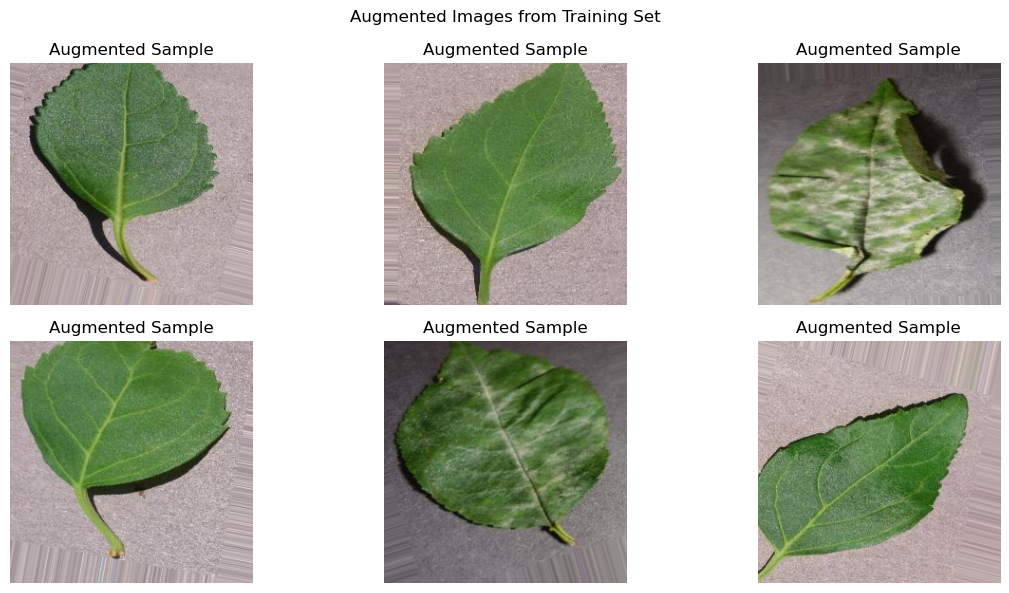

In [9]:
# Visualize augmented images from the training set
import matplotlib.pyplot as plt

augmented_images, _ = next(train_data)

plt.figure(figsize=(12, 6))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_images[i])
    plt.axis("off")
    plt.title("Augmented Sample")
plt.suptitle("Augmented Images from Training Set")
plt.tight_layout()
plt.show()